<a href="https://colab.research.google.com/github/Ananya-AJ/CMPE255-Data-Mining/blob/main/timeseries_exovars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#restart runtime after running the below
#!pip uninstall pycaret
!pip install pycaret-ts-alpha
!pip install pycaret-ts-alpha
!pip install Jinja2==2.11.3
!pip install markupsafe==2.0.1

In [ ]:
!pip install pandas
!pip install kaggle
!pip install kaleido


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d htagholdings/property-sales


mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/162k [00:00<?, ?B/s]
100% 162k/162k [00:00<00:00, 31.4MB/s]


In [ ]:
!unzip /content/property-sales.zip

Archive:  /content/property-sales.zip
  inflating: ma_lga_12345.csv        
  inflating: raw_sales.csv           


In [ ]:
import kaggle
import pandas as pd
import numpy as np
import kaleido
import plotly.express as px
import matplotlib.pyplot as plt

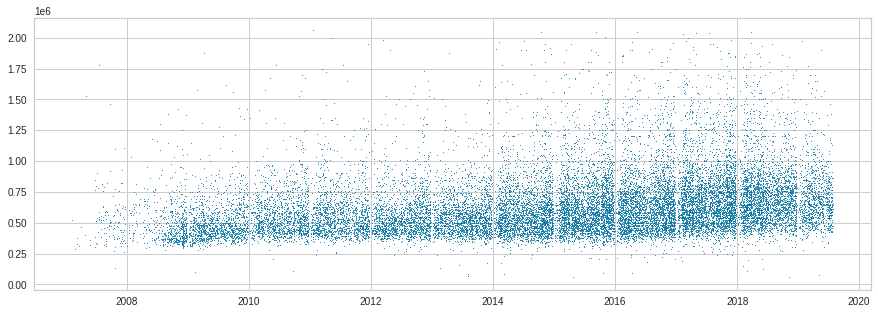

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df=pd.read_csv('/content/raw_sales.csv')
df=df[df.propertyType=='house'] #Let's limit the scope of this problem to houses only
df['datesold'] = pd.to_datetime(df['datesold'])
df=df.drop(columns=['postcode', 'propertyType'])
df = df[np.abs(df.price - df.price.mean()) <= (5.0 * df.price.std())] # Clean the outliers
%matplotlib inline 
plt.figure(figsize=(15,5))
plt.plot_date(df['datesold'], df['price'], xdate=True, markersize=1)

In [ ]:
df=pd.read_csv('/content/ma_lga_12345.csv')
df=df[df.type=='house'] #Let's limit the scope of this problem to houses only
df['saledate'] = pd.to_datetime(df['saledate'])
df.tail()

,saledate,MA,type,bedrooms
195,2018-09-30,1007114,house,5
196,2018-12-31,1002323,house,5
197,2019-03-31,998136,house,5
198,2019-06-30,995363,house,5
199,2019-09-30,970268,house,5


In [ ]:
df=df.pivot(index='saledate', columns='bedrooms', values='MA').interpolate(method='linear', limit_direction='both')
df.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


<AxesSubplot:xlabel='saledate'>

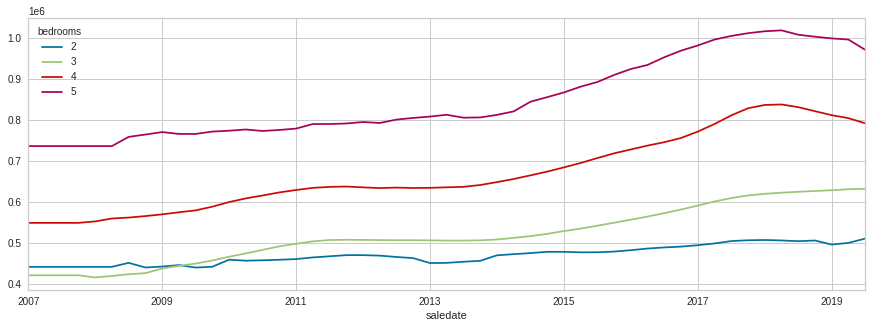

In [ ]:
%matplotlib inline 
df.plot(figsize=(15,5))

fix overlapping lines

<AxesSubplot:xlabel='saledate'>

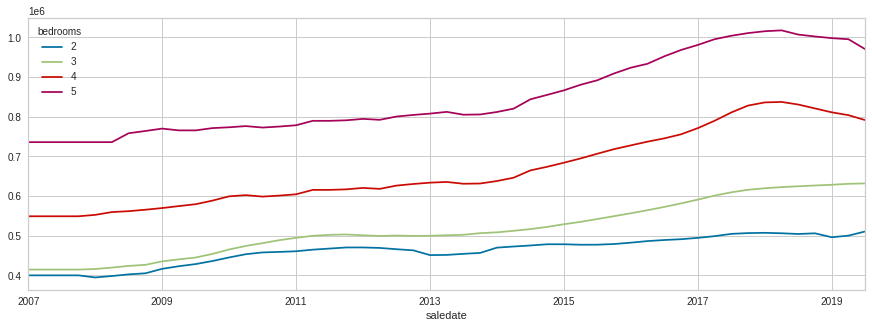

In [ ]:
def separate_series(df):
    columns = list(df) 
    for col in columns: 
        if col== columns[-1]:
            break
        #Calculate average difference between 2 and 3 bedrooms for the recent  1/3 of the dataframe
        diff_mean= (df[col+1][:-int(len(df)/3)]-df[col][:-int(len(df)/3)]).mean()
        #Where 2 br price is higher than that of 3 br, replace it with 3 br price minus the diff
        #do_they_intersect = False if df[col].loc[df[col] >= df[col+1], ].empty else True
        #if do_they_intersect:
        df.loc[df[col] > df[col+1]-diff_mean, col] = df[col+1]-diff_mean
    return df
df=separate_series(df)
df.plot(figsize=(15,5))

In [ ]:
#Split the data into train and test
train = df[:int(0.9*(len(df)))]
test = df[int(0.9*(len(df))):]

#Fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train, freq='Q-DEC')
model_fit = model.fit()

#Forecast based on train data
forecast = model_fit.forecast(model_fit.endog, steps=len(test))

In [ ]:
cols = df.columns
pred = pd.DataFrame(index=test.index, data=forecast,columns=[cols])
pred=pred.astype(int)
pred.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,507480,631399,861752,1045546
2018-12-31,507833,637650,875549,1061382
2019-03-31,508310,644176,890014,1077831
2019-06-30,508891,650995,905172,1094935
2019-09-30,509559,658120,921046,1112734


<AxesSubplot:xlabel='saledate'>

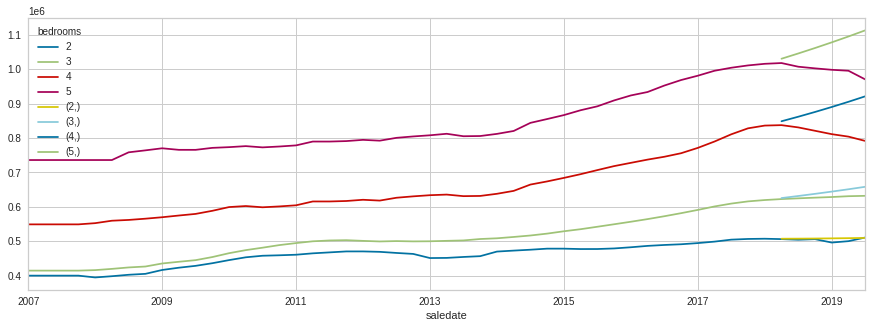

In [ ]:
ax = df.plot()
pred.plot(ax=ax,figsize=(15,5))

In [ ]:
from pycaret.time_series import *
from pycaret.regression import *
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


exploratory analysis

In [ ]:
eda = TSForecastingExperiment()

In [ ]:
cols = df.columns
pred = pd.DataFrame(index=test.index, data=forecast,columns=[cols])
pred=pred.astype(int)
pred.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,507480,631399,861752,1045546
2018-12-31,507833,637650,875549,1061382
2019-03-31,508310,644176,890014,1077831
2019-06-30,508891,650995,905172,1094935
2019-09-30,509559,658120,921046,1112734


<AxesSubplot:xlabel='saledate'>

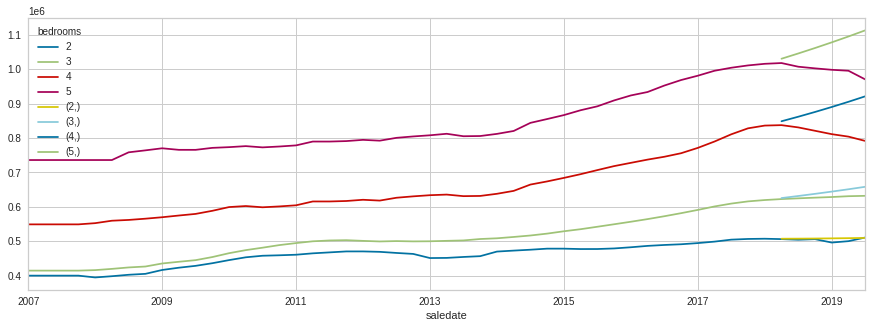

In [ ]:
#Plot actuals (df) and forecast (pred) on the same chart
ax = df.plot()
pred.plot(ax=ax,figsize=(15,5))